## Dynamic Derivation With JAX

In [2]:
import jax
import jax.numpy as jnp

print(jax.__version__)

0.4.31


In [3]:
def terminate():
    import sys
    sys.exit(0)

In [15]:
def generate_random_number(key):
    key, subkey = jax.random.split(key)
    return jax.random.normal(subkey), key



key = jax.random.PRNGKey(42)
print(type(key))

numbers = list()
for _ in range(5):
    number, key = generate_random_number(key)
    numbers.append(number)

numbers

<class 'jaxlib.xla_extension.ArrayImpl'>


[Array(1.3694694, dtype=float32),
 Array(-0.19947024, dtype=float32),
 Array(-2.2982783, dtype=float32),
 Array(0.44459623, dtype=float32),
 Array(0.08887016, dtype=float32)]

In [2]:
def softmax(x):
    exps = jnp.exp(x - jnp.max(x, keepdims=True)) 
    
    # max along axis=1(check among columns, horizontal direction) and shape[0] same with inputs
    return exps / jnp.sum(exps, axis=1, keepdims=True)

def sigmoid(x):
    exps = jnp.exp(x - jnp.max(x, keepdims=True)) 
    return 1 / (1 + exps)

def relu(x):
    return jnp.maximum(0, x)

# not used
def binary_cross_entropy(y_true, y_pred):
    # Clip y_pred to avoid log(0) infinity errors
    y_pred = jnp.clip(y_pred, 1e-7, 1 - 1e-7)
    bce = - (y_true * jnp.log(y_pred) + (1 - y_true) * jnp.log(1 - y_pred))
    return jnp.mean(bce)

def categorical_cross_entropy(y_true_one_hot, preds_prob):
    preds_prob = jnp.clip(preds_prob, 1e-7, 1 - 1e-7)
    loss = -jnp.sum(y_true_one_hot * jnp.log(preds_prob), axis=1)
    return jnp.mean(loss)

def layer_pass(X, W, b, activation):
    z = jnp.dot(X, W) + b
    a = activation(z)
    return a

def forward_prop(X, W1, W2, b1, b2): # len(W)=2 
    a1 = layer_pass(X, W1, b1, relu)
    y_pred = layer_pass(a1, W2, b2, softmax)
    return y_pred

def mean_squared_error(y_true, y_pred):
    return jnp.mean((y_true - y_pred) ** 2)

def compute_loss(params, X, y_true):
    W1, W2, b1, b2 = params
    y_pred = forward_prop(X, W1, W2, b1, b2)

    y_true_one_hot = jax.nn.one_hot(y_true.flatten(), num_classes=3)
    # print(y_true_one_hot.shape)
    loss = categorical_cross_entropy(y_true_one_hot, y_pred)
    # print(y_pred.shape)
    # print(y_pred[:5])
    # print(sum(y_pred[0]))
    # print(y_true_one_hot[:5])
    # print(loss)
    return loss

### Train Perceptron With JAX

In [3]:
def xavier_init(shape, key):
    in_dim, out_dim = shape
    scale = jnp.sqrt(2.0 / (in_dim + out_dim))
    return scale * jax.random.normal(key, shape)


In [4]:
def update_grads(X, y_true, params: dict, grads: dict): # two layer

    # Compute gradients for all parameters simultaneously
    grads_new = jax.grad(compute_loss)(tuple(params.values()), X, y_true)
    grads.update({
        "dW1": grads_new[0],
        "dW2": grads_new[1],
        "db1": grads_new[2],
        "db2": grads_new[3]
    })

In [66]:
def sgd_optimizer(params: dict, grads: dict, learning_rate=0.01):
    for key in params.keys():
        # print(key)
        # print(params.get(key), grads.get(key))
        params[key] = params[key] - (learning_rate * grads.get(f"d{key}"))

def momentum_optimizer(params, grads, velocity, lr=0.01, momentum=0.9):
    # print(velocity)
    velocity = {v_key : ((momentum * v) + (lr * g)) for (v_key, v), (g_key, g) in zip(velocity.items(), grads.items())}
    # print("after")
    # print(velocity)
    # print(grads)
    # print(velocity)
    # print(params)
    # print("params_new")
    params_new = {p_key: (p - v) for (p_key, p), (v_key, v) in zip(params.items(), velocity.items())}
    # print(params_new)
    params.update(params_new)
    return velocity

In [70]:
from sklearn.datasets import load_iris
import numpy as np

# Load the Iris dataset
iris = load_iris()

# Convert to NumPy arrays
X = iris.data
y_true = iris.target.reshape(150,1)

key = jax.random.PRNGKey(0)
key2 = jax.random.PRNGKey(1)
key3 = jax.random.PRNGKey(2)
key4 = jax.random.PRNGKey(3)
W1 = xavier_init((4,5), key) # 4 feature, 5 neurons
W2 = xavier_init((5,3), key2) # 5 feature, 3 neurons
b1 = xavier_init((1,5), key3) # single number for all neurons
b2 = xavier_init((1,3), key4) # single number for all neurons

print(X.shape)
print(W1.shape)
print(W2.shape)
print(b1.shape)
print(b2.shape)
print(y_true.shape)

(150, 4)
(4, 5)
(5, 3)
(1, 5)
(1, 3)
(150, 1)


In [76]:
EPOCHS= 500
learning_rate = 0.01
losses = []

velocity = {
    "VW1": jnp.zeros_like(W1),
    "VW2": jnp.zeros_like(W2),
    "Vb1": jnp.zeros_like(b1),
    "Vb2": jnp.zeros_like(b2)
}

params = {
    "W1": W1,
    "W2": W2,
    "b1": b1,
    "b2": b2
}

grads = {
    "dW1": None,
    "dW2": None,
    "db1": None,
    "db2": None
}
    

for i in range(EPOCHS):
    loss = compute_loss(tuple(params.values()), X, y_true)
    losses.append(loss)
        
    if i % 10 == 0:
        print(f"Epoch {i}: Loss = {loss}")

    # terminate()

    # print(grads)
    update_grads(X, y_true, params, grads)
    # print(grads)
    # Unpack the gradients
    # print("******************************")
    # print(params)
    sgd_optimizer(params, grads, learning_rate)

    # print(params)
    # velocity = momentum_optimizer(params, grads, velocity, learning_rate, momentum=0.9)
    # print("after")
    # print(params)
    # terminate()

    # print(params)
    
    
    # dW1, dW2, db1, db2 = grads
    


    # W1 -= learning_rate * dW1
    # b1 -= learning_rate * db1
    # W2 -= learning_rate * dW2
    # b2 -= learning_rate * db2

print(f"Final loss for Basic Stochastic Gradient Descent {loss}")

Epoch 0: Loss = 7.8339738845825195
Epoch 10: Loss = 1.5221583843231201
Epoch 20: Loss = 0.9218798875808716
Epoch 30: Loss = 0.8521625995635986
Epoch 40: Loss = 0.8207283020019531
Epoch 50: Loss = 0.7917216420173645
Epoch 60: Loss = 0.7636833786964417
Epoch 70: Loss = 0.736781895160675
Epoch 80: Loss = 0.7112037539482117
Epoch 90: Loss = 0.6871157884597778
Epoch 100: Loss = 0.6645432114601135
Epoch 110: Loss = 0.6434626579284668
Epoch 120: Loss = 0.6236882209777832
Epoch 130: Loss = 0.6051700711250305
Epoch 140: Loss = 0.5877184271812439
Epoch 150: Loss = 0.5712056756019592
Epoch 160: Loss = 0.5558803677558899
Epoch 170: Loss = 0.5416065454483032
Epoch 180: Loss = 0.528174877166748
Epoch 190: Loss = 0.5157079100608826
Epoch 200: Loss = 0.5040467381477356
Epoch 210: Loss = 0.4930591881275177
Epoch 220: Loss = 0.48269084095954895
Epoch 230: Loss = 0.4728342890739441
Epoch 240: Loss = 0.46349066495895386
Epoch 250: Loss = 0.4545932114124298
Epoch 260: Loss = 0.4460965096950531
Epoch 270: L

In [77]:
EPOCHS= 500
learning_rate = 0.01
losses = []

velocity = {
    "VW1": jnp.zeros_like(W1),
    "VW2": jnp.zeros_like(W2),
    "Vb1": jnp.zeros_like(b1),
    "Vb2": jnp.zeros_like(b2)
}

params = {
    "W1": W1,
    "W2": W2,
    "b1": b1,
    "b2": b2
}

grads = {
    "dW1": None,
    "dW2": None,
    "db1": None,
    "db2": None
}
    

for i in range(EPOCHS):
    loss = compute_loss(tuple(params.values()), X, y_true)
    losses.append(loss)
        
    if i % 10 == 0:
        print(f"Epoch {i}: Loss = {loss}")

    # terminate()

    # print(grads)
    update_grads(X, y_true, params, grads)
    # print(grads)
    # Unpack the gradients
    # print("******************************")
    # print(params)
    # sgd_optimizer(params, grads, learning_rate)

    # print(params)
    velocity = momentum_optimizer(params, grads, velocity, learning_rate, momentum=0.9)
    # print("after")
    # print(params)
    # terminate()

    # print(params)
    
    
    # dW1, dW2, db1, db2 = grads
    


    # W1 -= learning_rate * dW1
    # b1 -= learning_rate * db1
    # W2 -= learning_rate * dW2
    # b2 -= learning_rate * db2a
print(f"Final loss for Momentum Powered Stochastic Gradient Descent {loss}")
    

Epoch 0: Loss = 7.8339738845825195
Epoch 10: Loss = 1.5230131149291992
Epoch 20: Loss = 1.1088820695877075
Epoch 30: Loss = 1.0809684991836548
Epoch 40: Loss = 0.9332161545753479
Epoch 50: Loss = 0.8371097445487976
Epoch 60: Loss = 0.7539142966270447
Epoch 70: Loss = 0.6944913268089294
Epoch 80: Loss = 0.6479361057281494
Epoch 90: Loss = 0.6111301183700562
Epoch 100: Loss = 0.5815879702568054
Epoch 110: Loss = 0.5573979020118713
Epoch 120: Loss = 0.5370681881904602
Epoch 130: Loss = 0.5195696949958801
Epoch 140: Loss = 0.5041471719741821
Epoch 150: Loss = 0.4904071092605591
Epoch 160: Loss = 0.47799161076545715
Epoch 170: Loss = 0.46674495935440063
Epoch 180: Loss = 0.4564361572265625
Epoch 190: Loss = 0.4467473328113556
Epoch 200: Loss = 0.4374750256538391
Epoch 210: Loss = 0.4285256564617157
Epoch 220: Loss = 0.4198397099971771
Epoch 230: Loss = 0.41136831045150757
Epoch 240: Loss = 0.40307721495628357
Epoch 250: Loss = 0.3949459493160248
Epoch 260: Loss = 0.38696396350860596
Epoch 2

: 

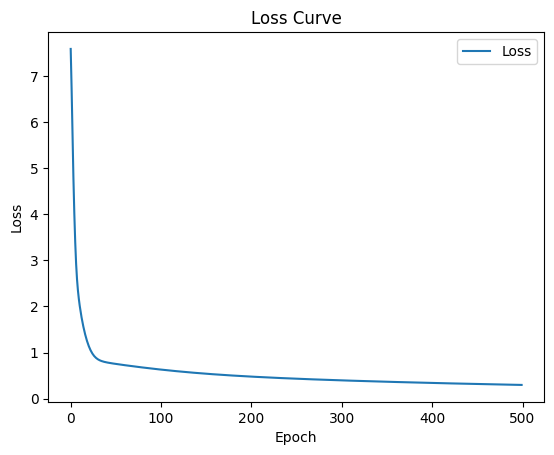

In [24]:
import matplotlib.pyplot as plt
def draw_loss(losses):
    plt.plot(range(EPOCHS), losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

draw_loss(losses)

# TODO ->  precision, recall impl. 

In [25]:
def accuracy(y_pred, y_true):
    preds = jnp.argmax(y_pred, axis=1, keepdims=True)
    return jnp.mean(preds == y_true)

In [28]:

y_pred = forward_prop(X, *tuple(params.values()))

accuracy(y_pred, y_true)

Array(0.9666667, dtype=float32)